# Rosbag Shortening Script
## Requirements
1. Script in folder
2. Checks for non-shortened .bag files
3. Filters index based on threshold
4. Finds appropriate start and end times
5. Shortens .bag into _shortened.bag files
6. Logs every changes made
7. Makes visualising changes possible through matplotlib if yes
8. Delete original .bag if yes
9. Handles error accordingly

In [ ]:
# Linux commands used to split rosbags - only method that worked for me
%matplotlib inline
import os
import rosbag
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Test part

In [54]:
bag_name = 'autocross_13_47_15.bag'
outbag_name = bag_name[0:-4] + '_shortened.bag'
bag = rosbag.Bag('autocross_13_47_15.bag')

vx = []
vy = []
vz = []
rostime_list = []
time_list = []

for topic, msg, time in bag.read_messages(topics=['/estimation/velocity']):
    if topic == '/estimation/velocity':
        vx.append(msg.twist.twist.linear.x)
        vy.append(msg.twist.twist.linear.y)
        vz.append(msg.twist.twist.angular.z)
        rostime_list.append(time)

start = bag.get_start_time()
end = bag.get_end_time()
duration = end - start

In [55]:
# get time in sec
for time in rostime_list:
    time_list.append(time.to_sec() - start)

print('Duration: ' + str(duration) + ' s')

Duration: 220.2858567237854 s


## New start and end function
Determines the start and end of a function

In [98]:
def new_start_end(rostime_list, vx, threshold=0.05):
    ind_list = []
    for ind, time in enumerate(rostime_list):
        if (vx[ind] >= threshold):
                ind_list.append(ind)
    
    new_start = rostime_list[ind_list[0]].to_sec()
    new_end = rostime_list[ind_list[len(ind_list) - 1]].to_sec()

    ### TROUBLESHOOTING ###
    # print(type(new_start))
    # print(type(rostime_list[0]))
    # print(type(start)

    # carry out operations after to_sec() conversion
    # rosbag filter works with to_sec() converted rostime objects only (tested)

    if (new_start - rostime_list[0].to_sec() > 10.0):
        print('Start extended')
        new_start = new_start - 10.0
    if (rostime_list[len(rostime_list) - 1].to_sec() - new_end > 10.0):
        print('End extended')
        new_end = new_end + 10.0

    new_duration = new_end- new_start
    print('New duration: ' + str(new_duration) + ' s')
    start_end = [new_start, new_end]

    return start_end

## Check files function
Checks which files need shortening

In [96]:
def check_files_in_folder(folder_path, suffix='_shortened.bag'):
    if not os.path.isdir(folder_path):
        print(f"The folder path '{folder_path}' is invalid.")
        return []
    
    valid_files = []
    rosbag_list = []
    to_shorten = []

    for file_name in os.listdir(folder_path):
        # Ensures we are only checking files, not directories
        full_path = os.path.join(folder_path, file_name)
        if (os.path.isfile(full_path) and file_name.endswith(suffix)):
            valid_files.append(file_name)
    
    for file_name in os.listdir(folder_path):
        if (file_name.endswith('.bag') and os.path.getsize(file_name) > 1):
            rosbag_list.append(file_name)

    for val in valid_files:
        for b in rosbag_list:
            if not (b.endswith(suffix)):
                if not (b[0:-4] == val[0:-14]):
                    #print(b[0:-4] + ' is already shortened. Skipped...')
                    to_shorten.append(b)
                #else:
                    #print(b[0:-4] + ' is not shortened yet. Will shorten...')
    return to_shorten

## Plot function

In [97]:
def plot_bag(time_list, vx, rostime_list, threshold=0.05):
    # determine new times for plot
    new_time_list = []
    new_vx = []
    start_end = new_start_end(rostime_list, vx, threshold)
    for i, time in enumerate(time_list):
        if (time >= start_end[0] - start and time <= start_end[1] - start):
            new_time_list.append(time)
            new_vx.append(vx[i])


    plt.figure(figsize=(8, 6))
    plt.plot(time_list, vx, label="Unshortened")
    plt.plot(new_time_list, new_vx, label="Shortened")
    plt.title(label="/estimation/velocity.twist.twist.linear.x vs Time", fontsize=14)
    plt.xlabel(xlabel="Time (s)", fontsize=12)
    plt.ylabel(ylabel="/estimation/velocity.twist.twist.linear.x (m/s)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Start extended
New duration: 50.003987312316895 s


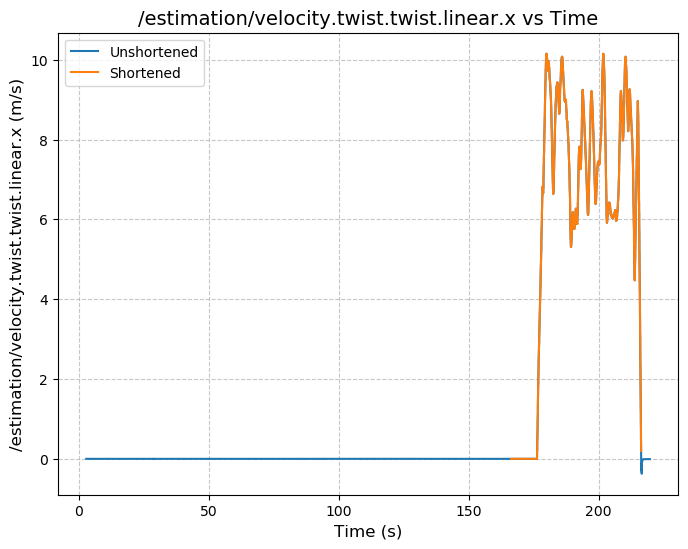

In [63]:
plot_bag(time_list, vx, rostime_list)

## Shorten function

In [ ]:
def shorten():
    to_shorten_list = check_files_in_folder(os.getcwd())

    for file in os.listdir(os.getcwd()):
        if (file in to_shorten_list):
            bag_name = file
            outbag_name = bag_name[0:-4] + '_shortened.bag'
            bag = rosbag.Bag(file)
            vx = []
            vy = []
            vz = []
            rostime_list = []
            time_list = []
            for topic, msg, time in bag.read_messages(topics=['/estimation/velocity']):
                if topic == '/estimation/velocity':
                    vx.append(msg.twist.twist.linear.x)
                    vy.append(msg.twist.twist.linear.y)
                    vz.append(msg.twist.twist.angular.z)
                    rostime_list.append(time)
            start = bag.get_start_time()
            end = bag.get_end_time()
            duration = end - start
            # get time in sec
            for rostime in rostime_list:
                time_list.append(rostime.to_sec() - start)

            print('Duration: ' + str(duration) + ' s')

            print('{0} will be shortened to {1}.'.format(bag_name, outbag_name))
            plot_bag(time_list, vx, rostime_list)

            # ask based on plot whether to shorten
            #short = input('Proceed with shortening? Y/n')
            short = 'Y'
            if (short == 'Y' or short == 'y'):
                start_end = new_start_end(rostime_list, vx)
                os.system('rosbag filter {0} {1} "t.secs >= {2} and t.secs <= {3}"'.format(bag_name, outbag_name, str(start_end[0]), str(start_end[1])))

                #delete = input('Delete original bag to free up space? Y/n')
                delete = 'n'
                if (delete == 'Y' or delete == 'y'):
                    os.remove(file)


#start_end = new_start_end(rostime_list, vx)
    
# extract output bag
# os.system('rosbag filter {0} {1} "t.secs >= {2} and t.secs <= {3}"'.format(bag_name, outbag_name, str(new_start), str(end)))

Duration: 220.2858567237854 s
autocross_13_47_15 (copy).bag will be shortened to autocross_13_47_15 (copy)_shortened.bag.
Start extended
New duration: 50.003987312316895 s


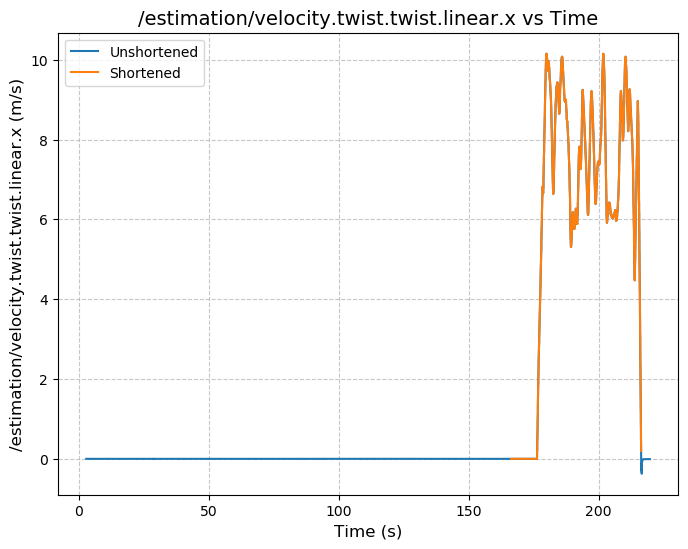

error here
Start extended
New duration: 50.003987312316895 s


sh: 1: Syntax error: "(" unexpected


In [106]:
shorten()

In [ ]:
bag_name = 'autocross_13_47_15.bag'
outbag_name = bag_name[0:-4] + '_shortened.bag'
bag = rosbag.Bag('autocross_13_47_15.bag')

vx = []
vy = []
vz = []
rostime_list = []
time_list = []

for topic, msg, time in bag.read_messages(topics=['/estimation/velocity']):
    if topic == '/estimation/velocity':
        vx.append(msg.twist.twist.linear.x)
        vy.append(msg.twist.twist.linear.y)
        vz.append(msg.twist.twist.angular.z)
        rostime_list.append(time)

start = bag.get_start_time()
end = bag.get_end_time()
duration = end - start

In [87]:
to_shorten_list = check_files_in_folder(os.getcwd())
print(to_shorten_list)

['autocross_13_47_15 (copy).bag']


In [109]:
print(start)
print(rostime_list[0].to_sec())
print(start - rostime_list[0].to_sec())

1723117635.5713034
1723117638.4737542
-2.9024507999420166
